In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.patches as patches

from google.colab import drive

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PolynomialFeatures
from sklearn.linear_model import TweedieRegressor


## Load data 

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI831 AI in Marketing/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI831 AI in Marketing/"
os.chdir(root_dir + project_folder)

Mounted at /content/drive
['MMAI 831 AI in Marketing AIOS Assignemt..ipynb', 'MMAI831 AIOS2023.docx', 'MMM_Store sales.csv']


In [ ]:
df=pd.read_csv('MMM_Store sales.csv')

In [ ]:
# Store Advertising ($)---------------------------store
# Billboard Advertising ($)-----------------------billboard 
# Print Advertising ($)---------------------------printout
# control variables such as Price ($)-------------price
# Satisfaction------------------------------------sat
# Competitor Advertising ($)----------------------comp
df.head()

,Unnamed: 0,store,billboard,printout,sat,comp,price,sales
0,1,1698,698,556,68,607,95,13605.61191
1,2,2069,1075,775,72,637,101,19142.67334
2,3,2271,615,772,71,761,95,15027.62340
3,4,1413,1158,1098,79,1183,98,16589.65910
4,5,2107,1175,386,77,940,97,21887.58210


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   int64  
 1   store       1000 non-null   int64  
 2   billboard   1000 non-null   int64  
 3   printout    1000 non-null   int64  
 4   sat         1000 non-null   int64  
 5   comp        1000 non-null   int64  
 6   price       1000 non-null   int64  
 7   sales       1000 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


## Visualization

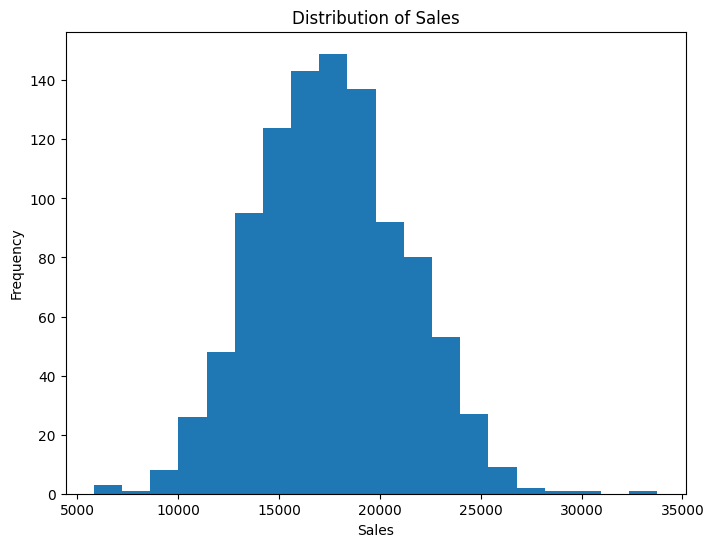

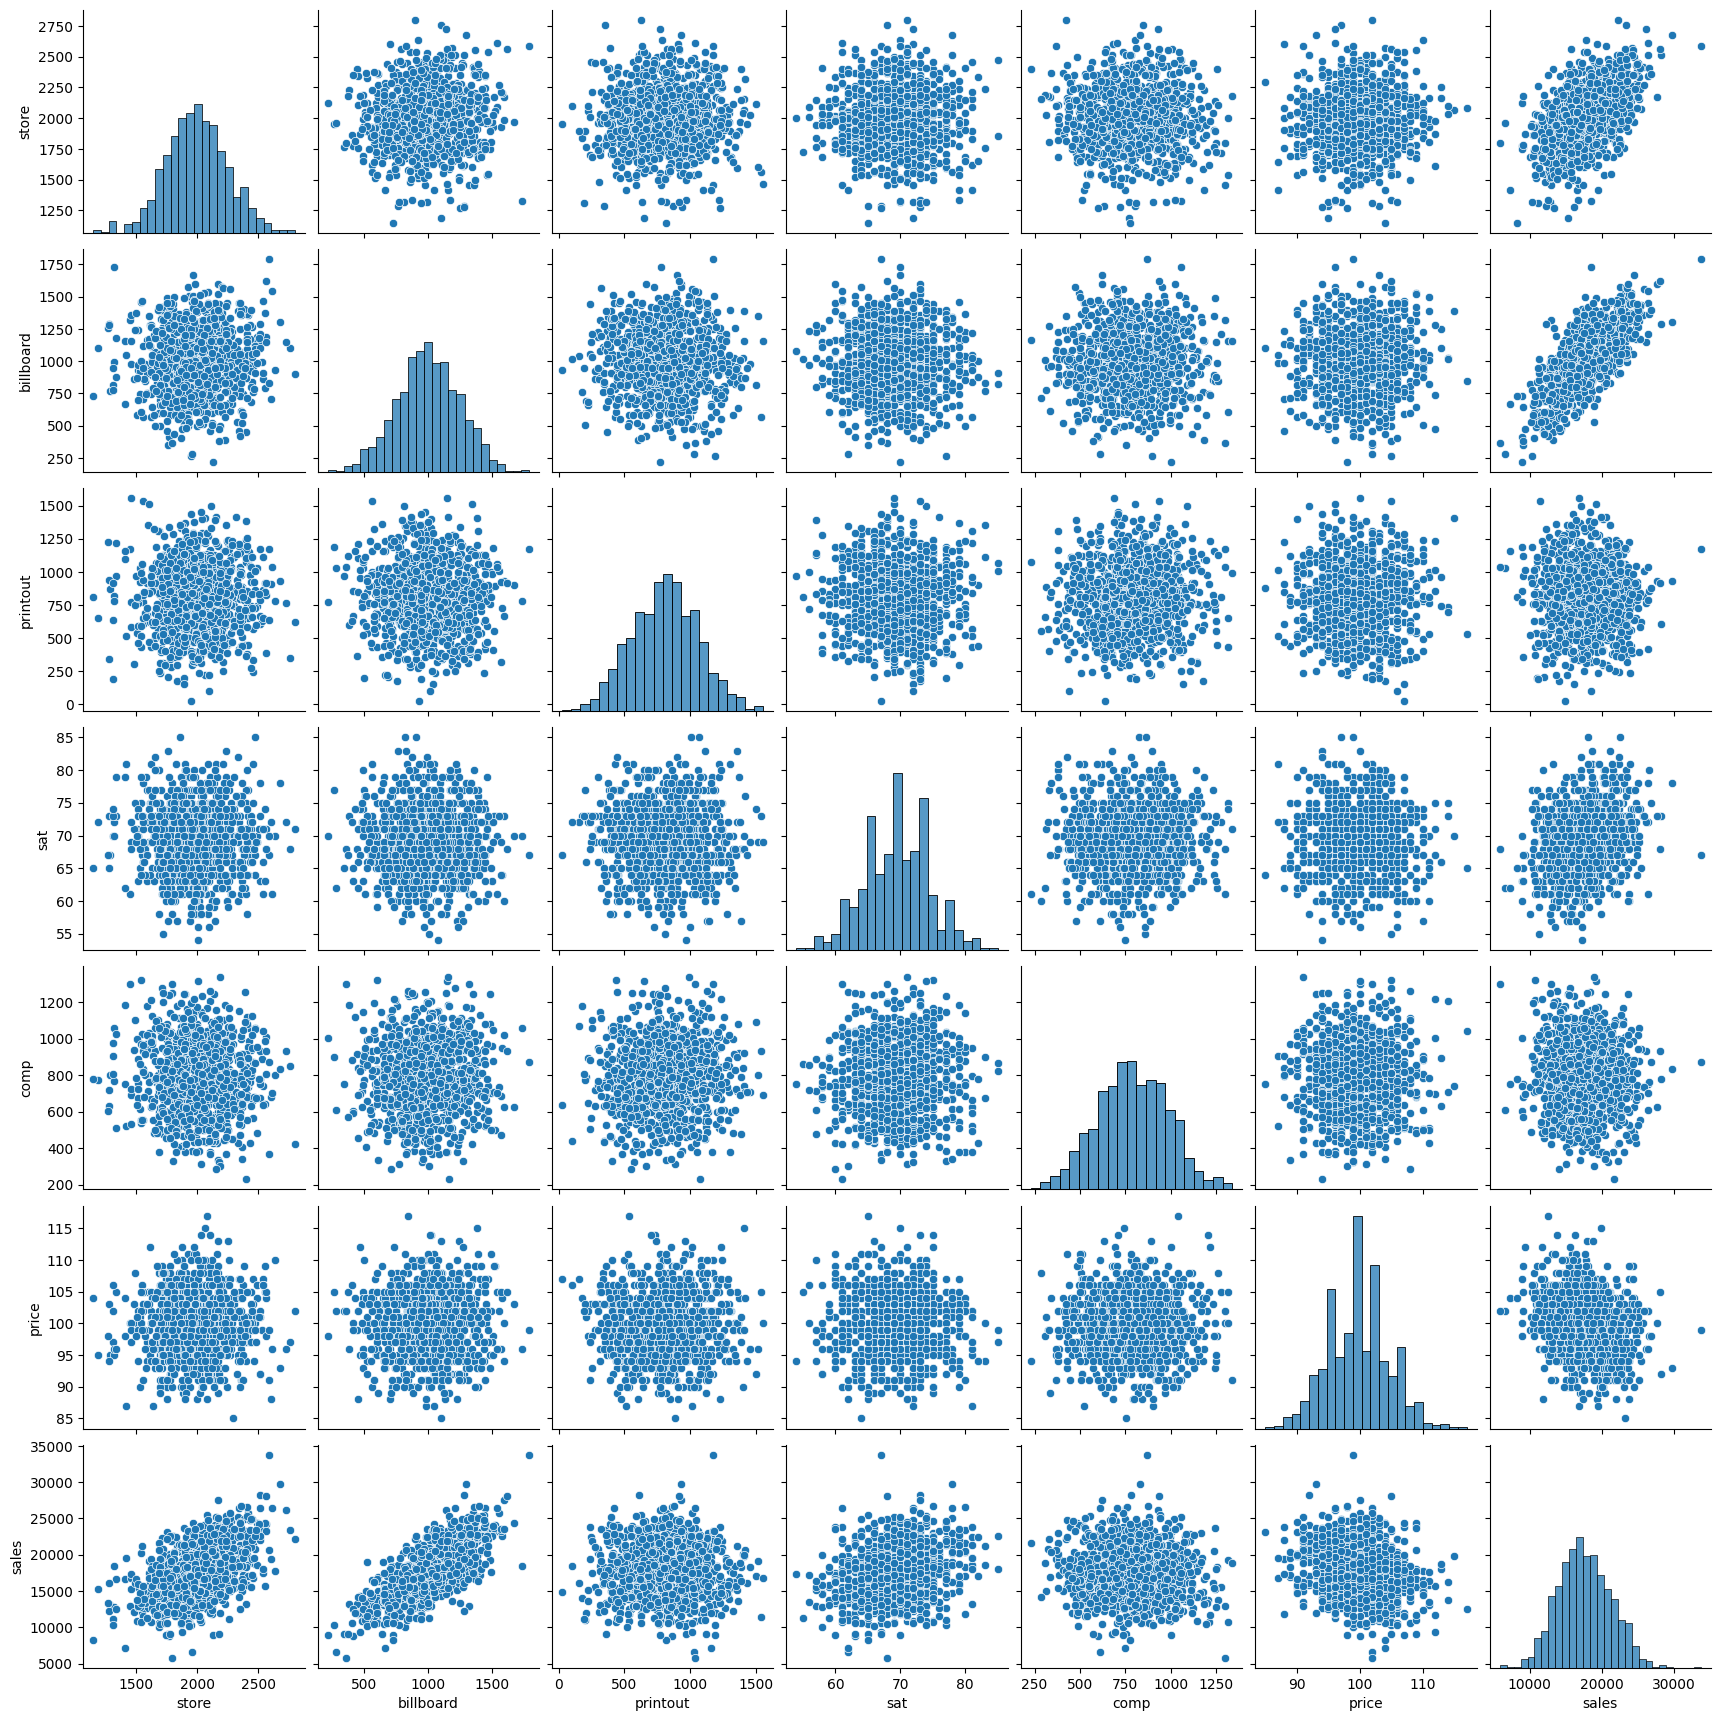

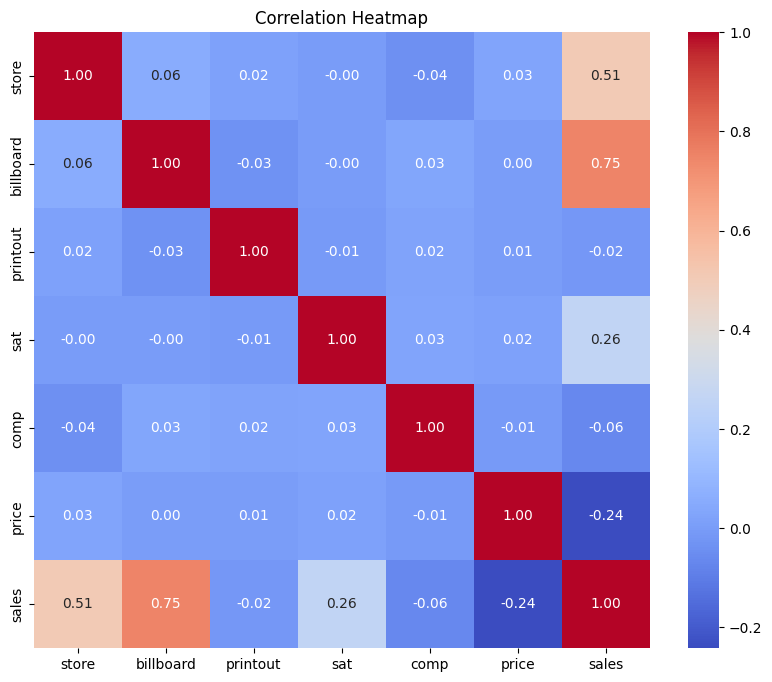

In [ ]:
# Histogram of the 'sales' variable
plt.figure(figsize=(8, 6))
plt.hist(df['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Pairwise scatter plot
sns.pairplot(df[['store', 'billboard', 'printout', 'sat', 'comp', 'price', 'sales']])
plt.show()

# Correlation heatmap
corr = df[['store', 'billboard', 'printout', 'sat', 'comp', 'price', 'sales']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

## Data Preparation

In [ ]:
# Prepare the data
X = np.column_stack((df.store, df.billboard, df.printout, df.sat, df.comp, df.price))
y = df.sales

In [ ]:
# Add pairwise interactions
interaction_terms = [
    X[:, 0] * X[:, 1],  # Store x Billboard
    X[:, 0] * X[:, 2],  # Store x Printout
    X[:, 1] * X[:, 2]   # Billboard x Printout
]
X_interactions = np.column_stack(interaction_terms)


# Combine original features and interaction features
X_combined = np.column_stack((X, X_interactions))

In [ ]:
# Split the data into training and test sets

# Use X for not using interation terms and X_combined to use them.

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

## Parametric Model

In [ ]:
# Create the Parametric Model Without the pairwise interactions
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()
print(results.summary())
# Access the R-squared value
OLS_r2 = results.rsquared
print("R-squared:", OLS_r2)


# Make predictions on the test set
X_test_const = sm.add_constant(X_test)
y_pred = results.predict(X_test_const)

# Calculate RMSE
OLS_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("Root Mean Squared Error:", OLS_rmse)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1076.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        18:21:41   Log-Likelihood:                -6239.2
No. Observations:                 750   AIC:                         1.250e+04
Df Residuals:                     740   BIC:                         1.254e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8537.0889   1847.546      4.621      0.0

AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) 

**No Interaction:**

No Iteraction Sale = -100.6715 + 6.8757(store) + 10.9230(billboard) + 0.0247(printout) + 201.9269(satisfaction) - 1.4992(Competitor adv) - 198.6216(price)

R-squared: 0.923052428448062

Root Mean Squared Error: 1050.2144496570309

**Interaction Added:**

Pairwise Iteraction Sale = 8537.0889 + 2.1535(store) + 2.7350(billboard) + 0.7912(printout) + 201.8006(satisfaction) - 1.5363(Competitor adv) - 198.9881(price) + 0.0045(store X billboard) + 0.0001(store X printout) - 0.001(billboard X printout)

## Machine Leaning Models

### Linear Regression

In [ ]:
# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(mse)
print("Root Mean Squared Error:", lr_rmse)
lr_r2 = r2_score(y_test, y_pred)
print("R-squared score:", lr_r2)

n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - lr_r2) * ((n - 1) / (n - p - 1))
print("Adjusted R-squared:", adjusted_r2)


Root Mean Squared Error: 1005.4690491068036
R-squared score: 0.916476007060854
Adjusted R-squared: 0.9133438573256359


In [ ]:
# Retrieve the coefficients
coefficients = lr_model.coef_

# Print the coefficients
for i, coefficient in enumerate(coefficients):
    print(f"Feature {i+1}: {coefficient}")
intercept = lr_model.intercept_

print("Intercept (X0):", intercept)


Feature 1: 2.1534577277073716
Feature 2: 2.7350356227489154
Feature 3: 0.7912026746883801
Feature 4: 201.80055263818022
Feature 5: -1.5362949616159471
Feature 6: -198.98809974944263
Feature 7: 0.004513249932774244
Feature 8: 0.00012130875946469999
Feature 9: -0.0009902143318422374
Intercept (X0): 8537.088903380163


Same coefficients as OLS but through a different approach, OLS uses statistical formulas but Scikit learn uses machine learning.

No Interaction Sale = -100.6715 + 6.8757(store) + 10.9230(billboard) + 0.0247(printout) + 201.9269(satisfaction) - 1.4992(Competitor adv) - 198.6216(price)  

Pairwise Iteraction Sale = 8537.0889 + 2.1535(store) + 2.7350(billboard) + 0.7912(printout) + 201.8006(satisfaction) - 1.5363(Competitor adv) - 198.9881(price) + 0.0045(store X billboard) + 0.0001(store X printout) - 0.001(billboard X printout)

### Lasso & Ridge

Did not see much improvement

In [ ]:

# Create and train the Lasso regression model
lasso_model = Lasso(alpha = 20)  # Set the alpha parameter (regularization strength) as desired
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print("Adjusted R-squared:", adjusted_r2)


Root Mean Squared Error: 1005.2158416645696
R-squared score: 0.9165180694866859
Adjusted R-squared: 0.9133874970924366


In [ ]:
from sklearn.linear_model import Ridge

# Create and train the Ridge regression model
ridge_model = Ridge(alpha= 2)  # Set the alpha parameter (regularization strength) as desired
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
print("Adjusted R-squared:", adjusted_r2)


Root Mean Squared Error: 1005.4614553837297
R-squared score: 0.9164772686723931
Adjusted R-squared: 0.9133451662476079


### Polynomial regression (second degree X^2)

In [ ]:

from sklearn.linear_model import LinearRegression

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree as needed
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Create and train the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_poly = poly_model.predict(X_test_poly)

# Evaluate the polynomial regression model
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)
adjusted_r2_poly = 1 - (1 - r2_poly) * ((n - 1) / (n - p - 1))

print("Polynomial Regression:")
print("Root Mean Squared Error:", rmse_poly)
print("R-squared score:", r2_poly)
print("Adjusted R-squared:", adjusted_r2_poly)

Polynomial Regression:
Root Mean Squared Error: 1074.3013817281035
R-squared score: 0.9046488130271066
Adjusted R-squared: 0.9010731435156232


In [ ]:
# Get the number of features
num_features = X_train.shape[1]

# Generate the feature names
feature_names = ['1']  # Intercept term
for feature_index in range(num_features):
    for degree in range(1, poly_features.degree + 1):
        feature_names.append(f'x{feature_index + 1}^{degree}')

# Print the polynomial regression coefficients and formula
print("Polynomial Regression Coefficients:")
for feature, coefficient in zip(feature_names, coefficients):
    print(f"{feature}: {coefficient}")

# Generate the polynomial regression formula
formula = f"y = {intercept}"
for feature, coefficient in zip(feature_names[1:], coefficients[1:]):
    formula += f" + ({coefficient:.2f}) * {feature}"

print("Polynomial Regression Formula:")
print(formula)


Polynomial Regression Coefficients:
1: 2.1534577277073716
x1^1: 2.7350356227489154
x1^2: 0.7912026746883801
x2^1: 201.80055263818022
x2^2: -1.5362949616159471
x3^1: -198.98809974944263
x3^2: 0.004513249932774244
x4^1: 0.00012130875946469999
x4^2: -0.0009902143318422374
Polynomial Regression Formula:
y = 8537.088903380163 + (2.74) * x1^1 + (0.79) * x1^2 + (201.80) * x2^1 + (-1.54) * x2^2 + (-198.99) * x3^1 + (0.00) * x3^2 + (0.00) * x4^1 + (-0.00) * x4^2


x1: store, x2: billboard etc.

OLS Result: 

No Interaction Sale = -100.6715 + 6.8757(store) + 10.9230(billboard) + 0.0247(printout) + 201.9269(satisfaction) - 1.4992(Competitor adv) - 198.6216(price) 

Pairwise Iteraction Sale = 8537.0889 + 2.1535(store) + 2.7350(billboard) + 0.7912(printout) + 201.8006(satisfaction) - 1.5363(Competitor adv) - 198.9881(price) + 0.0045(store X billboard) + 0.0001(store X printout) - 0.001(billboard X printout)

### TweedieRegressor

In [ ]:
# Create and train the Tweedie regression model
tweedie_model = TweedieRegressor(power=0, alpha=1, max_iter=200, link='identity') 
# You can adjust the power and alpha parameters as needed
tweedie_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tweedie = tweedie_model.predict(X_test)

# Evaluate the Tweedie regression model
mse_tweedie = mean_squared_error(y_test, y_pred_tweedie)
rmse_tweedie = np.sqrt(mse_tweedie)
r2_tweedie = r2_score(y_test, y_pred_tweedie)
adjusted_r2_tweedie = 1 - (1 - r2_tweedie) * ((n - 1) / (n - p - 1))

print("Tweedie Regression:")
print("Root Mean Squared Error:", rmse_tweedie)
print("R-squared score:", r2_tweedie)
print("Adjusted R-squared:", adjusted_r2_tweedie)


Tweedie Regression:
Root Mean Squared Error: 1627.3118895072512
R-squared score: 0.7812160645439772
Adjusted R-squared: 0.7730116669643763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


### XGBoost

Tree based models build an ensemble of decision trees and combine their predictions to make final predictions

In [ ]:
xgboost_reg = xgb.XGBRegressor(max_depth = 6, # the larger the more prone to overfit, range 3-10
                learning_rate = .006, # range [0,1], typically=0.01-0.2
                n_estimators = 1000,
                verbosity = 1,
                booster = "gbtree", # gblinear or dart
                n_jobs = -1,
                gamma = 0, # Minimum loss reduction required to split. range=[0,inf], The larger gamma is, the more conservative the algorithm will be.
                min_child_weight = 2, # used to restrict overfitting
                max_delta_step = 0,
                subsample = 0.2,
                colsample_bylevel = 0.5,
                reg_lambda = 0.03,
                random_state = 42,
                            
)

# Train the model
xgboost_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_reg.predict(X_test)

# Calculate RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", xgb_rmse)
xgb_r2 = r2_score(y_test, y_pred)
print("R-squared score:", xgb_r2)


Root Mean Squared Error: 1120.0659834613518
R-squared score: 0.8963519702934248


In [ ]:
# # Standardize the features , as all features are interms of $ cost so it doeas not help much
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the scaled data into training and test sets
# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# # Train the model
# xgboost_reg.fit(X_train_scaled, y_train)

# # Make predictions on the scaled test set
# y_pred_scaled = xgboost_reg.predict(X_test_scaled)

# # Calculate RMSE on the scaled predictions
# rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
# print("Root Mean Squared Error (Scaled Features):", rmse_scaled)


# r2 = r2_score(y_test, y_pred)
# print("R-squared score:", r2)


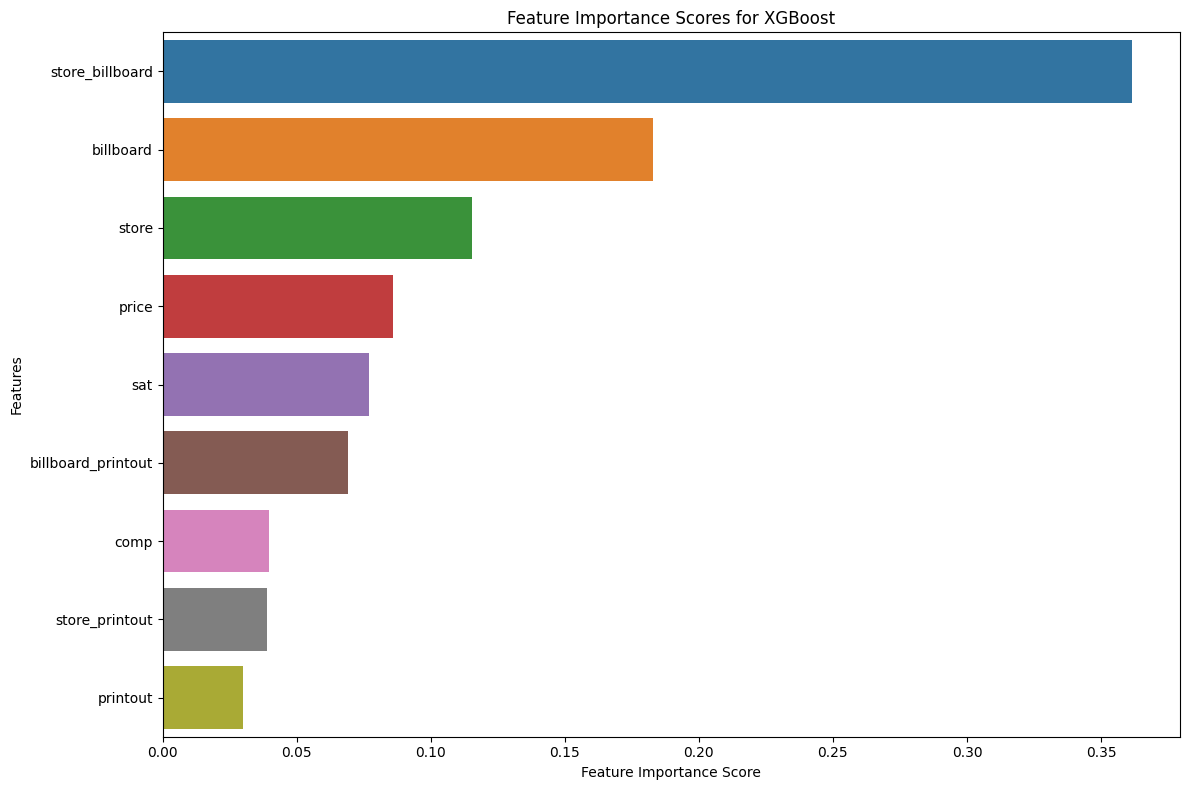

In [ ]:
# Convert X_train to DataFrame
X_train_df = pd.DataFrame(X_train, columns=['store', 'billboard', 'printout', 'sat', 'comp', 'price', 'store_billboard', 'store_printout', 'billboard_printout'])

# Calculate feature importance scores
xgboost_feature_scores = pd.Series(xgboost_reg.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

# Create bar plot of feature importance scores
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=xgboost_feature_scores, y=xgboost_feature_scores.index)
ax.set_title("Feature Importance Scores for XGBoost")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()


### LightGBM

In [ ]:
# importing the lightgbm module
import lightgbm as lgb
# initializing the model
LightGBM_reg = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves = 15,
    max_depth=6,
    learning_rate = 0.005,
    n_estimators=500,
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=42, 
    n_jobs=-1, 
    verbosity = 1,
    force_col_wise=True
    
)

# Train the model
LightGBM_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = LightGBM_reg.predict(X_test)

# Calculate RMSE
lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", lgbm_rmse)
lgbm_r2 = r2_score(y_test, y_pred)
print("R-squared score:", lgbm_r2)

[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 9
[LightGBM] [Info] Start training from score 17742.587997
Root Mean Squared Error: 1296.3790378005326
R-squared score: 0.8611525733789511


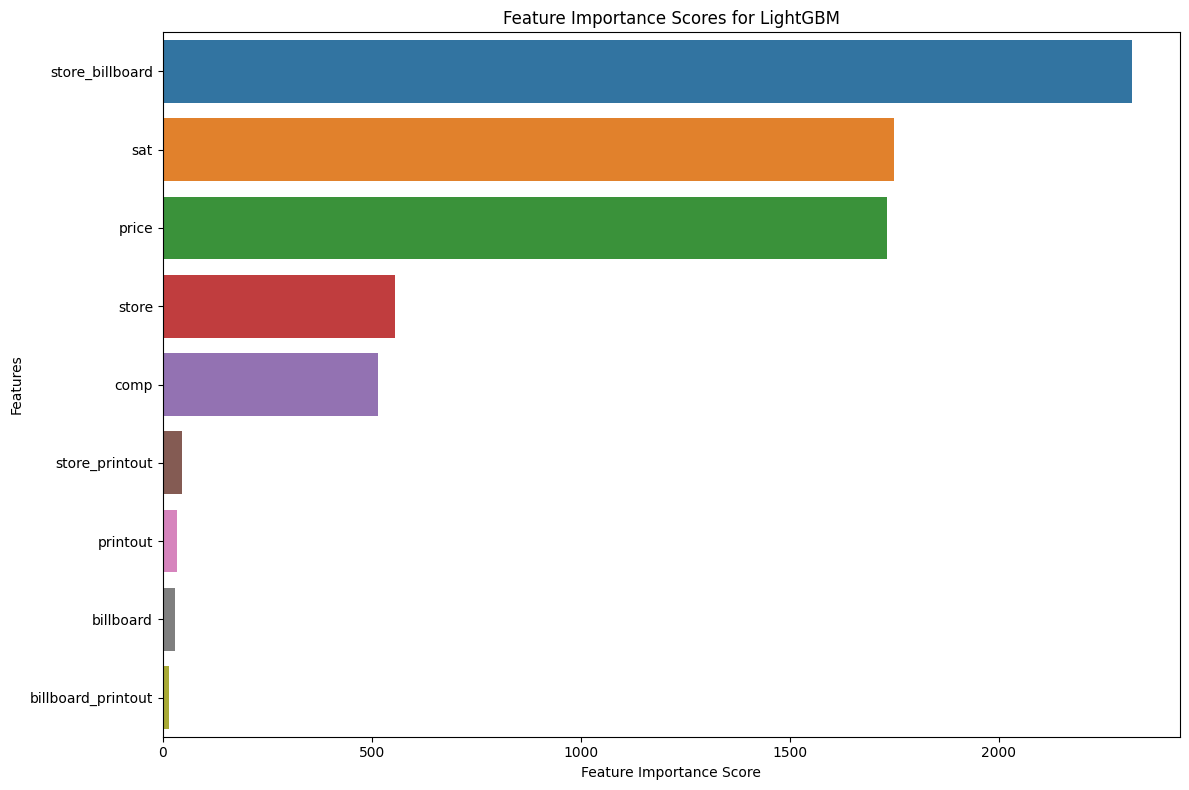

In [ ]:
# Calculate feature importance scores
lgbm_feature_scores = pd.Series(LightGBM_reg.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

# Create bar plot of feature importance scores
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=lgbm_feature_scores, y=lgbm_feature_scores.index)
ax.set_title("Feature Importance Scores for LightGBM")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor with specified parameters
rf_reg = RandomForestRegressor(
    n_estimators=2000,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_reg.predict(X_test)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rf_rmse)

# Calculate R-squared score
rf_r2 = r2_score(y_test, y_pred)
print("R-squared score:", rf_r2)


Root Mean Squared Error: 1260.4303661298147
R-squared score: 0.8687463013878198


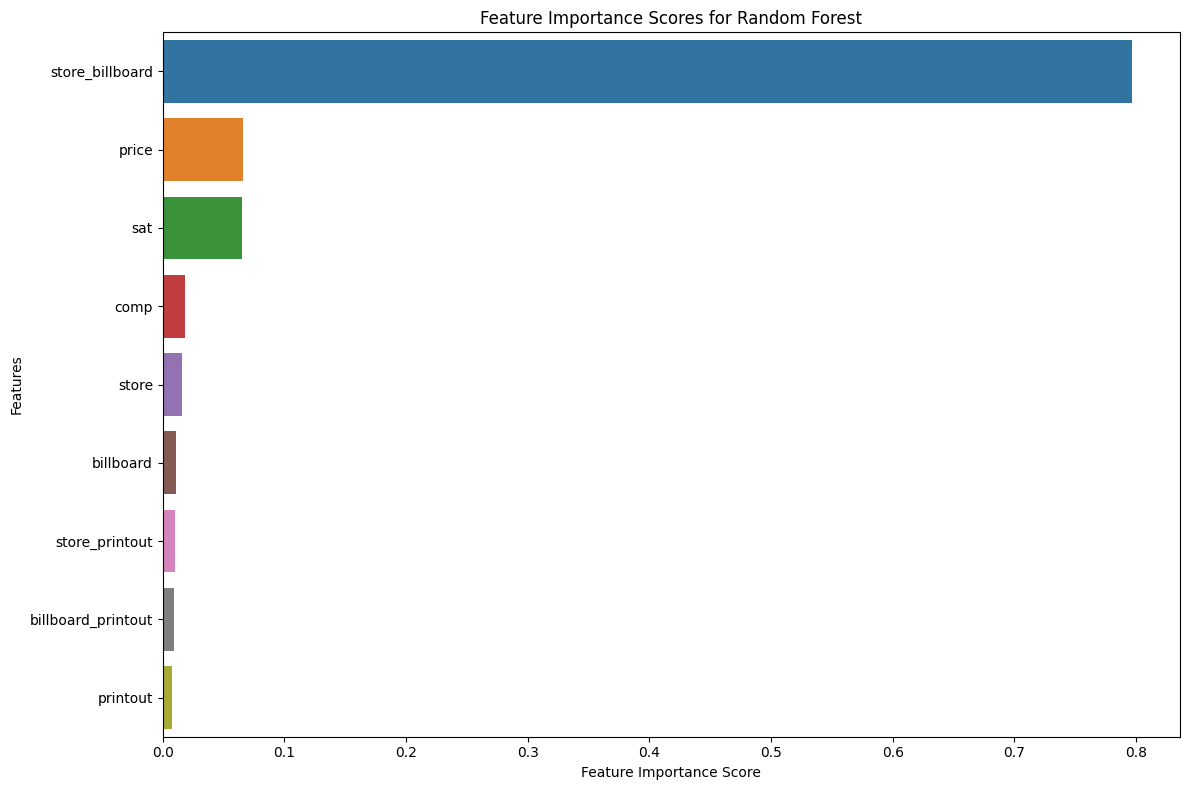

In [ ]:
# Calculate feature importance scores
rf_feature_scores = pd.Series(rf_reg.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

# Create bar plot of feature importance scores
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=rf_feature_scores, y=rf_feature_scores.index)
ax.set_title("Feature Importance Scores for Random Forest")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

### ADABoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
# Initialize the AdaBoost regressor with specified parameters
ada_reg = AdaBoostRegressor(
    n_estimators=5000,
    learning_rate=0.8,
    random_state=42
)

# Train the model
ada_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ada_reg.predict(X_test)

# Calculate RMSE
ada_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", ada_rmse)

# Calculate R-squared score
ada_r2 = r2_score(y_test, y_pred)
print("R-squared score:", ada_r2)


Root Mean Squared Error: 1242.4900798465105
R-squared score: 0.8724560992801086


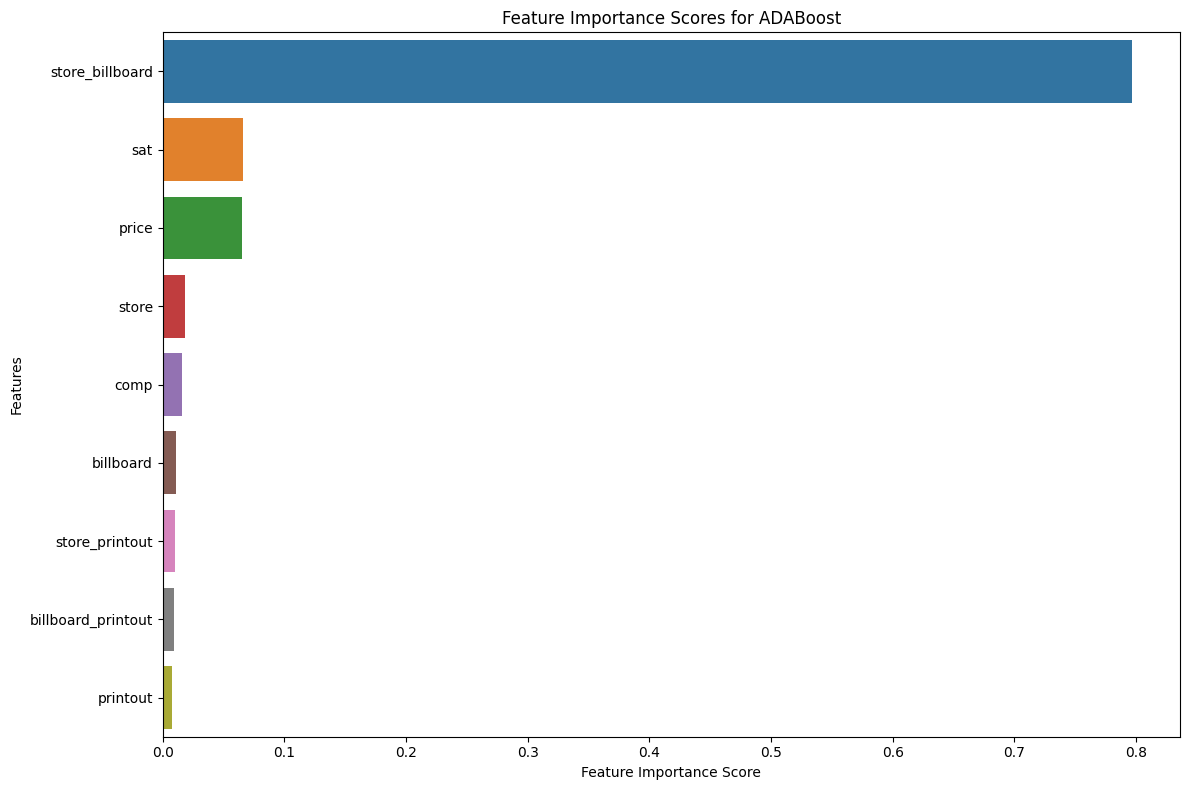

In [ ]:
# Calculate feature importance scores
ada_feature_scores = pd.Series(ada_reg.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

# Create bar plot of feature importance scores
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=rf_feature_scores, y=ada_feature_scores.index)
ax.set_title("Feature Importance Scores for ADABoost")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

# Final Results Plot

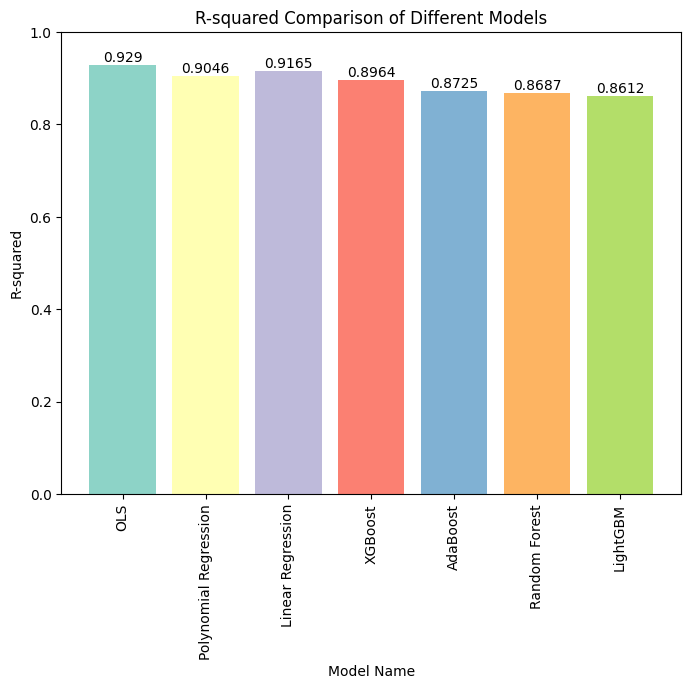

In [ ]:
# Models' names
model_names = ['OLS', 'Polynomial Regression', 'Linear Regression', 'XGBoost', 'AdaBoost', 'Random Forest', 'LightGBM']

# R-squared values
r2_values = [OLS_r2, r2_poly, lr_r2, xgb_r2, ada_r2, rf_r2, lgbm_r2]

# Specify colors for each bar
colors = sns.color_palette("Set3")[:len(model_names)]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, r2_values, color=colors)
plt.xlabel('Model Name')
plt.ylabel('R-squared')
plt.title('R-squared Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limits if needed
plt.xticks(rotation='vertical')

# Add values on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{round(height, 4)}", ha='center', va='bottom')


plt.show()


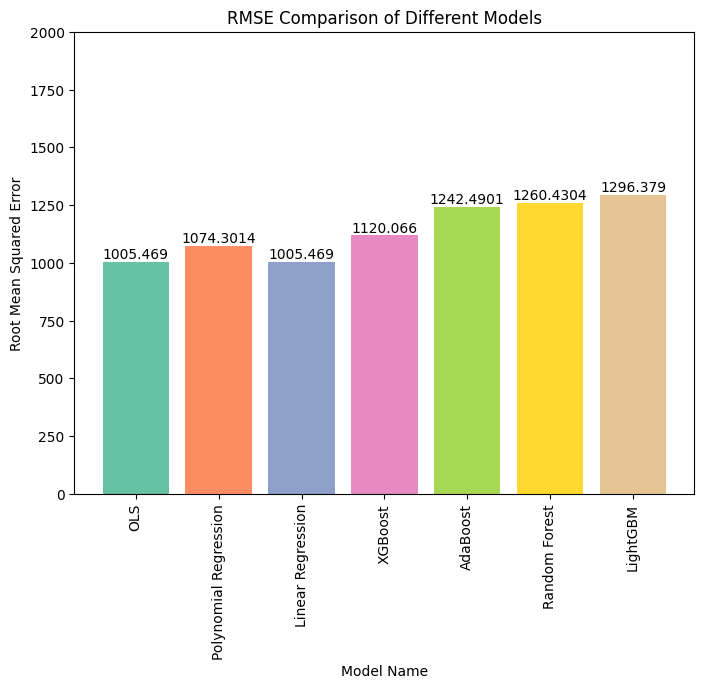

In [ ]:
# Models' names
model_names = ['OLS', 'Polynomial Regression', 'Linear Regression', 'XGBoost', 'AdaBoost', 'Random Forest', 'LightGBM']

# RMSE values
rmse_values = [OLS_rmse, rmse_poly, lr_rmse, xgb_rmse, ada_rmse, rf_rmse, lgbm_rmse]

# Specify colors for each bar
colors = sns.color_palette("Set2")[:len(model_names)]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, rmse_values, color=colors)
plt.xlabel('Model Name')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE Comparison of Different Models')
plt.ylim(0, 2000)  # Set the y-axis limits if needed
plt.xticks(rotation='vertical')

# Add values on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{round(height, 4)}", ha='center', va='bottom')


plt.show()